# Chapter 8

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np

import thinkstats2
import thinkplot

## The estimation game


Root mean squared error is one of several ways to summarize the average error of an estimation process.

In [3]:
def RMSE(estimates, actual):
    """Computes the root mean squared error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float RMSE
    """
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

The following function simulates experiments where we try to estimate the mean of a population based on a sample with size `n=7`.  We run `iters=1000` experiments and collect the mean and median of each sample.

In [4]:
import random

def Estimate1(n=7, iters=1000):
    """Evaluates RMSE of sample mean and median as estimators.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for _ in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('Experiment 1')
    print('rmse xbar', RMSE(means, mu))
    print('rmse median', RMSE(medians, mu))
    
Estimate1()

Experiment 1
rmse xbar 0.38065260533689316
rmse median 0.4600860138311369


Using $\bar{x}$ to estimate the mean works a little better than using the median; in the long run, it minimizes RMSE.  But using the median is more robust in the presence of outliers or large errors.


## Estimating variance

The obvious way to estimate the variance of a population is to compute the variance of the sample, $S^2$, but that turns out to be a biased estimator; that is, in the long run, the average error doesn't converge to 0.

The following function computes the mean error for a collection of estimates.

In [5]:
def MeanError(estimates, actual):
    """Computes the mean error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float mean error
    """
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

The following function simulates experiments where we try to estimate the variance of a population based on a sample with size `n=7`.  We run `iters=1000` experiments and two estimates for each sample, $S^2$ and $S_{n-1}^2$.

In [6]:
def Estimate2(n=7, iters=1000):
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('mean error biased', MeanError(estimates1, sigma**2))
    print('mean error unbiased', MeanError(estimates2, sigma**2))
    
Estimate2()

mean error biased -0.13486191178264054
mean error unbiased 0.009327769586919367


The mean error for $S^2$ is non-zero, which suggests that it is biased.  The mean error for $S_{n-1}^2$ is close to zero, and gets even smaller if we increase `iters`.

## The sampling distribution

The following function simulates experiments where we estimate the mean of a population using $\bar{x}$, and returns a list of estimates, one from each experiment.

In [7]:
def SimulateSample(mu=90, sigma=7.5, n=9, iters=1000):
    xbars = []
    for j in range(iters):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        xbars.append(xbar)
    return xbars

xbars = SimulateSample()

Here's the "sampling distribution of the mean" which shows how much we should expect $\bar{x}$ to vary from one experiment to the next.

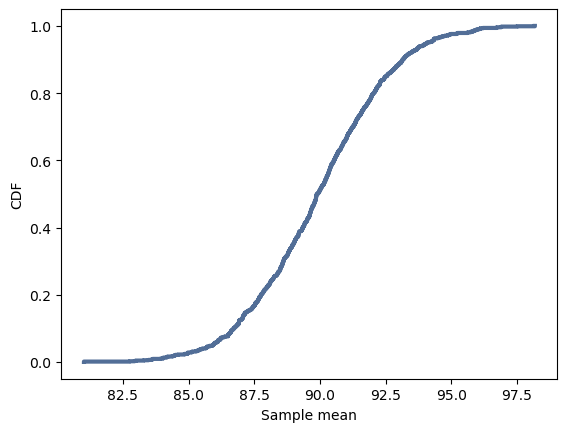

In [8]:
cdf = thinkstats2.Cdf(xbars)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Sample mean',
                 ylabel='CDF')

The mean of the sample means is close to the actual value of $\mu$.

In [9]:
np.mean(xbars)

89.94031414186729

An interval that contains 90% of the values in the sampling disrtribution is called a 90% confidence interval.

In [10]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(85.91035996052716, 94.07160399786184)

And the RMSE of the sample means is called the standard error.

In [11]:
stderr = RMSE(xbars, 90)
stderr

2.5407062361338353

Confidence intervals and standard errors quantify the variability in the estimate due to random sampling.

## Estimating rates

The following function simulates experiments where we try to estimate the mean of an exponential distribution using the mean and median of a sample. 

In [12]:
def Estimate3(n=7, iters=1000):
    lam = 2

    means = []
    medians = []
    for _ in range(iters):
        xs = np.random.exponential(1.0/lam, n)
        L = 1 / np.mean(xs)
        Lm = np.log(2) / thinkstats2.Median(xs)
        means.append(L)
        medians.append(Lm)

    print('rmse L', RMSE(means, lam))
    print('rmse Lm', RMSE(medians, lam))
    print('mean error L', MeanError(means, lam))
    print('mean error Lm', MeanError(medians, lam))
    
Estimate3()

rmse L 1.1076270722643282
rmse Lm 1.7828914738794606
mean error L 0.32552422189807184
mean error Lm 0.4693521452712887


The RMSE is smaller for the sample mean than for the sample median.

But neither estimator is unbiased.

## Exercises

**Exercise:** Suppose you draw a sample with size n=10 from an exponential distribution with λ=2. Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval.

Repeat the experiment with a few different values of `n` and make a plot of standard error versus `n`.



standard error 0.7959984592758925
confidence interval (1.3005752214139343, 3.7197305841437145)


0.7959984592758925

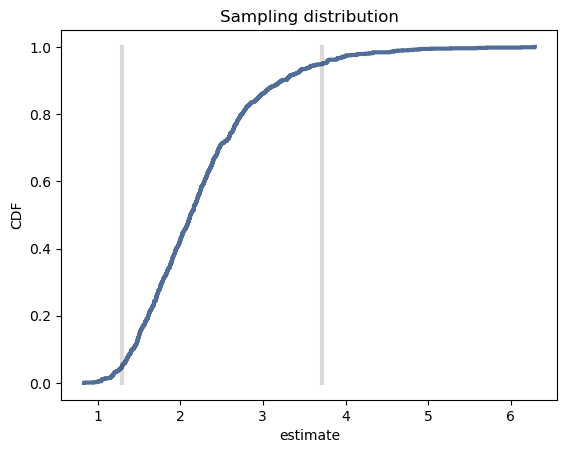

In [13]:
def SimulateSample(lam=2, n=10, iters=1000):
    """Sampling distribution of L as an estimator of exponential parameter.

    lam: parameter of an exponential distribution
    n: sample size
    iters: number of iterations
    """
    def VertLine(x, y=1):
        thinkplot.Plot([x, x], [0, y], color='0.8', linewidth=3)

    estimates = []
    for _ in range(iters):
        xs = np.random.exponential(1.0/lam, n)
        lamhat = 1.0 / np.mean(xs)
        estimates.append(lamhat)

    stderr = RMSE(estimates, lam)
    print('standard error', stderr)

    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print('confidence interval', ci)
    VertLine(ci[0])
    VertLine(ci[1])

    # plot the CDF
    thinkplot.Cdf(cdf)
    thinkplot.Config(xlabel='estimate',
                     ylabel='CDF',
                     title='Sampling distribution')

    return stderr

SimulateSample()

In [ ]:
# My conclusions:

# 1) With sample size 10:

# standard error 0.762510819389
# confidence interval (1.2674054394352277, 3.5377353792673705)

# 2) As sample size increases, standard error and the width of
#    the CI decrease:

# 10      0.90    (1.3, 3.9)
# 100     0.21    (1.7, 2.4)
# 1000    0.06    (1.9, 2.1)

# All three confidence intervals contain the actual value, 2.

**Exercise:** In games like hockey and soccer, the time between goals is roughly exponential. So you could estimate a team’s goal-scoring rate by observing the number of goals they score in a game. This estimation process is a little different from sampling the time between goals, so let’s see how it works.

Write a function that takes a goal-scoring rate, `lam`, in goals per game, and simulates a game by generating the time between goals until the total time exceeds 1 game, then returns the number of goals scored.

Write another function that simulates many games, stores the estimates of `lam`, then computes their mean error and RMSE.

Is this way of making an estimate biased?

In [14]:
def SimulateGame(lam):
    """Simulates a game and returns the estimated goal-scoring rate.

    lam: actual goal scoring rate in goals per game
    """
    goals = 0
    t = 0
    while True:
        time_between_goals = random.expovariate(lam)
        t += time_between_goals
        if t > 1:
            break
        goals += 1

    # estimated goal-scoring rate is the actual number of goals scored
    L = goals
    return L

**Exercise:**  In this chapter we used $\bar{x}$ and median to estimate µ, and found that $\bar{x}$ yields lower MSE. Also, we used $S^2$ and $S_{n-1}^2$ to estimate σ, and found that $S^2$ is biased and $S_{n-1}^2$ unbiased.
Run similar experiments to see if $\bar{x}$ and median are biased estimates of µ. Also check whether $S^2$ or $S_{n-1}^2$ yields a lower MSE.

In [15]:
def Estimate4(n=7, iters=100000):
    """Mean error for xbar and median as estimators of population mean.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('Experiment 1')
    print('mean error xbar', MeanError(means, mu))
    print('mean error median', MeanError(medians, mu))
    
Estimate4()

Experiment 1
mean error xbar -0.00039540785965883556
mean error median -0.0003705125022044895


In [16]:
def Estimate5(n=7, iters=100000):
    """RMSE for biased and unbiased estimators of population variance.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('Experiment 2')
    print('RMSE biased', RMSE(estimates1, sigma**2))
    print('RMSE unbiased', RMSE(estimates2, sigma**2))

Estimate5()

Experiment 2
RMSE biased 0.5149714504262839
RMSE unbiased 0.5778696336036423


In [17]:
# My conclusions:

#1) Based on the numbers given by the xbar and median it shows that neither is biased in terms of this experiment. 

#2) There is about 10% differnce between biased and unbiased. With unbiased being the higher of the two values. 